# Изучение архитектуры на основе U-Net в PyTorch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MVRonkin/for_course_DLCV/blob/main/workshops/WS8_UNet.ipynb)

## Импорт torch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
сolab_requirements = ["pip install albumentations==0.4.6",]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in сolab_requirements:
        run_subprocess_command(i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 4.2 MB/s eta 0:00:00
Preparing metadata (setup.py): started
Preparing metadata (setup.py): finished with status 'done'
Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ec2faef21417c262e07f460356a8cf16bc96c70fc4bcf0a9bab855e2c6d0cf6c
Stored in directory: /root/.cache/pip/wheels/84/ab/bb/5c36149e73c852c0fc8f278f457dd5b22df911cd65a542b16e
Successfully built albumentations
Attempting uninstall: albumentations
Found existing installation: albumentations 1.2.1
Uninstalling albumentations-1.2.1:
Successfully uninstalled albumentations-1.2.1


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

import albumentations 
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [4]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [5]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.13
Using device: cuda
cuda:  cu116
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 2


# Архитектура UNet и ее модификации

В предыдущих практиках по работе с `PyTorch` мы рассмотрели задачу классификации. Однако, это не едиственная задача, которую можно решать нейронными сетями. В данном примере рассмотрим задачу семантической сегментации.  

В задачах семантической сегметнации требуется выделение каких-либо объектов в выходных данных (например, изображении) из входных данных (например, входного изображения). Как правило, такие задачи решаются формированием карт признаков конечного размера (например, совпадающего с размером исходного изображения) и имеющих число каналов, соотвествующее числу классов. Затем по всем картам признаков проводится попиксельная классификация. 

В данном уроке мы будем будем решать задачу сематической сегментации архитектур на основе `U-Net`. Данная архитектура состоит из двух частей: энкодера и декодера. Обе части имеют следующее назначение.
* Энкодер (кодировщик) сжимает исходные данные в т.н. "набор карт латентных признаков". То есть выделить и "закодировать" признаки в заданное, достаточно большое, число карт признаков небольшого размера. Однако, особенностью энкодера является выделение и сохранение карт признаков на разных этапах сжатия.
* Декодер занимается раскодированием признаков в карыт выхондого размера. Однако, в архитектурах `U-Net`, такое раскодирование происходит с использованием информации, сохраненной энкодером на каждом из соответствующих этапов. Это достигается за счет соединения слоев, получаемых в декодере непосредственно и аналогичных по размеру слоев энкодера.

Отметим, что архитектура `U-Net` была предложенна в 2015 для решения ряда медицинских задач, офицальная статья может быть найдена по ссылке [тут](https://arxiv.org/abs/1505.04597). На данный момент семейство архитектур на базе `U-Net` является одним из наиболее популярных для решения задач семантической сегментации.

Схема данной сети показана на рисунке ниже.

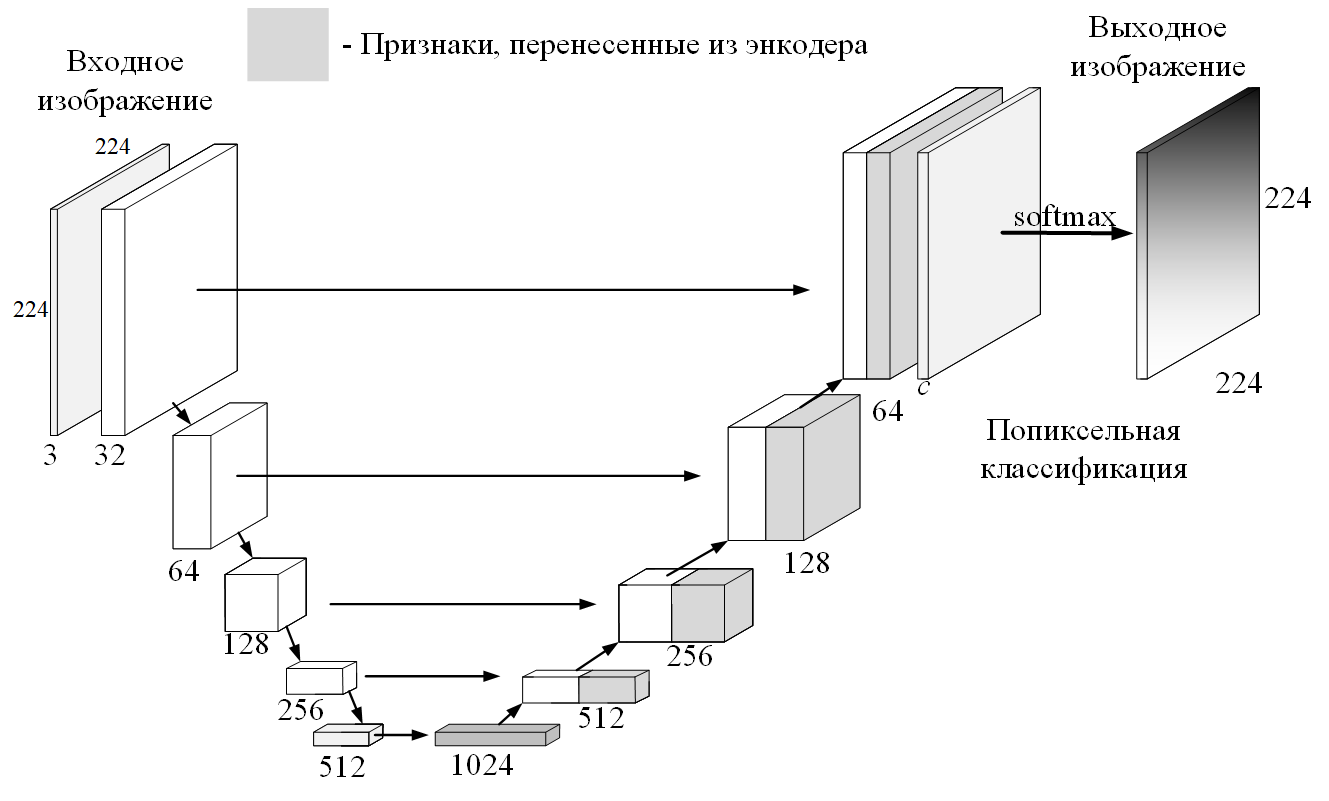
<!-- <img src='UNET.png' style="height: 600px; " /> -->


Также отметим, что на официальном сайте `PyTorch` может быть найден пример работы с `U-Net` при помощи `torch.hub` ([тут](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)). А также, порекомендуем сторонюю библиотеку для работы с моделями семантической сетментации [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch).

Перед тем как описать архитектуру загрузим набор данных. В этом примере мы будем использовать набор данных `The Oxford-IIIT Pet Dataset`, который может быть найден на [по официальной ссылке](https://www.robots.ox.ac.uk/~vgg/data/pets/). Набор данных содержит изображения кошек и собак, которые требуется сегментировать и аннотацию к каждому изорбажению.

Аннотация в данном случае подразумевает маску, по которой должен быть сегментирован объект на изображении. Все аннотации имеют размер, соответствующий изображению. Каждая маска может принимать одно из трех значений:
* 1 - пиксель пренадлежит классу петомец;
* 2 - пиксель пренадлежит классу фон;
* 3 - пиксель пренадлежит классу граница.
Однако, в данном примере мы будем рассматривать только 1 и 2-й классы. 

Отметим, что задача распознования границ объектов представляет отдельный класс задач семантической сегментации, подразумевающий специфичный вид функции потерь. 

Попробуем загрузить набор данных. В данном случа набор будет представлен двумя архивами, один с изображениями, и второй с их анннотацией. Отметим, что данный урок вдохнавлен [этим примером](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/).

Также отметим, что на самом деле набор данных входит в модуль `torchvision.datasetes`. Для вызова из набора можно воспользоваться следующим кодом.
```
trainvaldata = torchvision.datasets.OxfordIIITPet(root  = './data',
                                                  split = 'trainval', 
                                                  target_types = 'segmentation',
                                                  download  = True, 
                                                  transform = train_transforms)


testdata = torchvision.datasets.OxfordIIITPet(root = './data', 
                                             split = 'test', 
                                             target_types = 'segmentation',
                                             download  = True, 
                                             transform = test_transforms)
```                                             

In [6]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [7]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /content/data/pets/images.tar.gz to /content/data/pets


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /content/data/pets/annotations.tar.gz to /content/data/pets


Посмотрим содержания созданного архива. Архив содержит директорию изображениями `images` и директорию с аннотацией `images/trimaps`. Всего в архиве должно быть 7393 изображения. 

In [8]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))
# print('n anno = ',len(os.listdir(os.path.join(dataset_directory, content[0], "trimaps" ))))

['images', 'images.tar.gz', 'annotations', 'annotations.tar.gz']
n images =  7393


Теперь пробуем разбить изображения на тренировочную, валидационную и тестовую выборки. 

В тренировочную выборку поместим 6000 случайно выбранных изображений.
В тестовую выборку поместим 100 случайно выбранных изображений.

In [9]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

images_filenames = [i for i in images_filenames 
                        if os.path.splitext(i)[-1]                     
                            in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]
os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


Для загрузки наборов данных создаим свой загрузчик. Данная тема уже поднималась в рамках урока по основам работы с данными в `PyTorch`. Напомним, что  свой набор данных при помощи  класса наследника `Dataset`.
Загрузчик данных должен иметь следующий вид.
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

В нашем случае мы создадим загрузчик данных `PetsDataset`. Загрузчик буде позволять работать с заданным списком изображений, указанным в `images_filenames`. Изображения будут браться из директории `images_directory`, а маски из директории `masks_directory`. Для изображений будут доступны преобразования `transforms`. В рамках класса загрузчика функция `__getitem__` является основной. Она должна получать на входе номер элмента и выдавать для номера входные и выходные данные. Также класс будет содержать функцию `preprocess_mask`, цель которой в том, чтобы убрать ненужный класс рамок изображений. 

В этом уроке мы будем использовать сторонюю библиотеку для аугментации данных. Библиотека [`albumentation`](https://albumentations.ai/docs) является одним из наиболее популярных инструментов аугментации в задачах компьютерного зрения. Примеры использования данной бибилотеки для решения задач семантической сегментации могут быть найдены в официальной документации [тут](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/) и [тут](https://albumentations.ai/docs/examples/example_kaggle_salt/). Ипользование данной библиотеки подразумевает особый тип загрузки данных в `PyTorch`. В данном случае это сводится к модификации метода `__getitem__` и добавлении туда следующих строк кода:
```python
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]
```

In [10]:
from torch.utils.data import Dataset

class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):
        
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory
        
        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)
   
    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask
    
    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]
        
        path_ = os.path.join(self.images_directory, image_filename)    
        image = np.asarray(Image.open(path_).convert("RGB"))
        
        path_ = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png"))    
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask

In [11]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = A.Compose([A.Resize(280, 280),   
                             A.RandomCrop(256,256),
                             A.ShiftScaleRotate(0.2,0.2, 30),
                             A.RGBShift(25,25,25),
                             A.RandomBrightnessContrast(0.3,0.3),
                             A.Normalize(mean, std),
                             ToTensorV2(),])

test_transform = A.Compose([A.Resize(256, 256), 
                            A.Normalize(mean, std), 
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


Теперь попробуем визуализировать некоторые изображения и их маски. Для этого создадим функцию visualize_data

In [12]:
from PIL import Image
def visualize_dataset(dataset, samples=5, predicted_masks = None, mean = mean, std = std):
    dataset = copy.deepcopy(dataset)
    cols = 3 if predicted_masks else 2
    
    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))
    
    for i in range(samples):
        image, mask = dataset[i]
        
        image = image.data.cpu().numpy().transpose((1,2,0))
        image = np.clip(image*std + mean,0,1)
        
        mask = np.clip(mask,0,1)
               

        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image"); ax[i, 0].set_axis_off()
        ax[i, 1].imshow(mask.data.cpu().numpy(), interpolation="nearest")
        ax[i, 1].set_title("Ground Truth");  ax[i, 1].set_axis_off()     
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted Mask"); ax[i, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

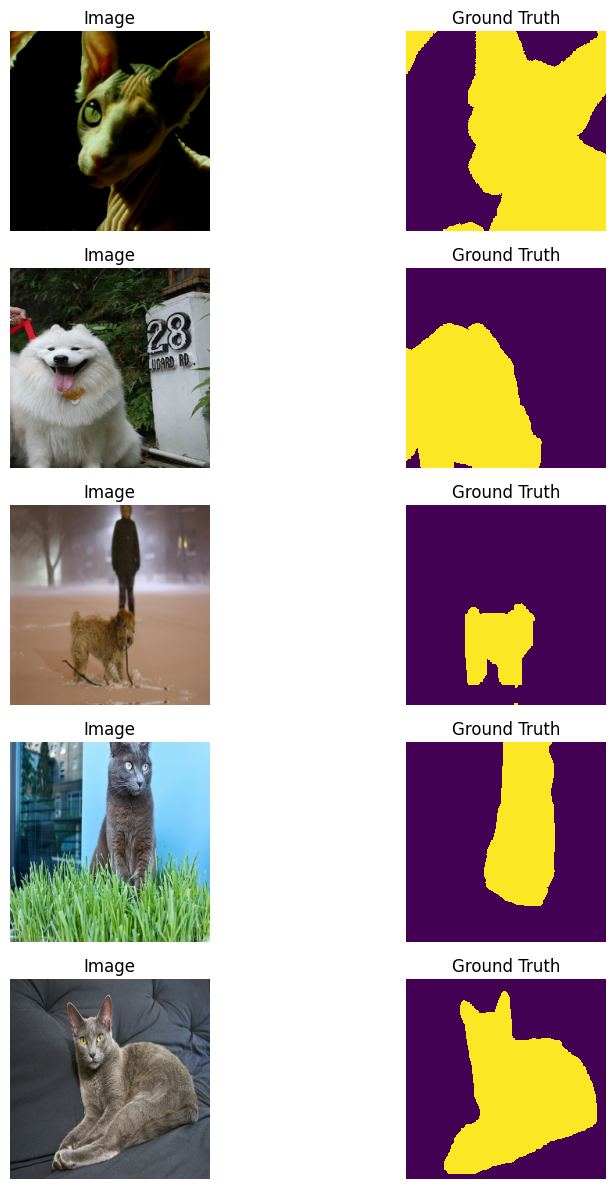

In [13]:
visualize_dataset(train_dataset, samples=5)

In [14]:
BATCH = 4

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda'), 'pin_memory':True}
else:
     kwarg = {'num_workers':0}

train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True,
                **kwarg)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

Теперь опишим стандартную архитектуру `U-Net`. В данном случае мы будем описывать архитектуры "с нуля".

Отметим, что при необходимости также можно ознакомится с [этим](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) примером. 


In [15]:
SIZE = 32

def conv_block(in_channels, out_channels, mid_channels = None):
    if mid_channels is None:
        mid_channels = out_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels,  mid_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),        
        nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):

    def __init__(self, n_channels = 1, n_class=1):
        super().__init__()
                
        self.down1 = conv_block(n_channels, SIZE)
        self.down2 = conv_block(SIZE,       SIZE*2)
        self.down3 = conv_block(SIZE*2,     SIZE*4)
        self.down4 = conv_block(SIZE*4,     SIZE*8)        

        self.maxpool  = nn.MaxPool2d(2)
        
        self.upsample = nn.Upsample(scale_factor=2, 
                                    mode='bilinear', 
                                    align_corners=True)
        
        
        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)
        self.up1 = conv_block(SIZE*2 + SIZE,   SIZE)
        
        self.out = nn.Conv2d(SIZE, n_class, 3, padding=1)
      
    #---------------------------------------------    
    def forward(self, x):
        
        #ENCODER
        conv1 = self.down1(x)
        x = self.maxpool(conv1)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down3(x)
        x = self.maxpool(conv3)   
        
        x = self.down4(x)
        
        #DECODER
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.up1(x)
        
        out = self.out(x)
        
        return out

In [16]:
model = UNet(n_channels=3, n_class=1)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

Для моделей семантической сегментации, как правило используется функция потерь, представляющая комбинацию кросс-энтропии и т.н. расстояния  `Dice`. Последние соотвествует 1 - т.н Коэффициент Серенса-Дайса (или `Dice`).

Метрика `Dice` представляет отношение удвоенной площади пересечения искомого объекта (макси) к сумме площадей искомого объекта и полученного по результатам работы нейронной сети. Расстояние, соответствующиее коэффициенту `Dice` расчитчвается как:

$$dice = 1 - \frac {2\cdot(A\cap B)}{|A|+|B|}$$

где $A,B$ - это площади полученного и искомого объектов, знак $\cap$ - это обозначение пересечения площадей.

Создадим дайс функцию потерь `dice_loss` и класс функуции потерь `DiceBCELoss`. Данный класс соответствует библиотеке `Loss Function Library`, которая может быть найдена по ссылке [тут](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook) и [тут](https://github.com/JunMa11/SegLoss/tree/master/losses_pytorch).

In [17]:
def dice_loss(pred, target, smooth=1):
    #flatten label and prediction tensors
    
    pred    = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()                            
    loss = 1 - (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)  
    
    return loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        self.weight = weight

    def forward(self, pred, target, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = torch.sigmoid(pred)       
        
        dice = dice_loss(pred, target, smooth=1)
        
        bce = F.binary_cross_entropy(pred.squeeze(), target.squeeze(), reduction='mean')
        dice_bce = self.weight*bce + dice*(1-self.weight)
        
        return dice_bce

In [18]:
LR = 0.001

model = model.to(device)

criterion = DiceBCELoss(weight = 0.5)

criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)



Для конечной функции потерь будем использовать комибнацию `Dice` и бинарной кросс энтропии (`BCE`), оба значения как правило суммируются с некоторыми весами.  Это связно с тем, что значения `BCE` более чувствительны к таким вещам, как небольшие изменения формы объекта, тогда как `Dice` более

Таким образом в функции потерь будет учитываться место объекта и его площадь (`Dice`), а также особенности формы объекта с точки зрения его параметров, например яркости или особенностей формы (например широховатости краев) (`BCE`).

In [19]:
def accuracy(y_pred, y):
    return 1-dice_loss(torch.sigmoid(y_pred), y, smooth=1)
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metrics( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion,metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metrics( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Проведем инициализацию модели

In [20]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear): 
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)
            
model.apply(init_weights);

In [21]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion,
                                                accuracy, 
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.444 | Train Acc: 66.74%
	 Val. Loss: 0.426 |  Val. Acc: 68.82%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 0.394 | Train Acc: 70.85%
	 Val. Loss: 0.441 |  Val. Acc: 69.17%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 49s
	Train Loss: 0.376 | Train Acc: 72.29%
	 Val. Loss: 0.341 |  Val. Acc: 75.17%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 50s
	Train Loss: 0.350 | Train Acc: 74.39%
	 Val. Loss: 0.320 |  Val. Acc: 75.90%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 49s
	Train Loss: 0.344 | Train Acc: 75.07%
	 Val. Loss: 0.357 |  Val. Acc: 74.71%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 50s
	Train Loss: 0.330 | Train Acc: 75.86%
	 Val. Loss: 0.281 |  Val. Acc: 76.61%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 50s
	Train Loss: 0.314 | Train Acc: 77.28%
	 Val. Loss: 0.259 |  Val. Acc: 79.04%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 50s
	Train Loss: 0.306 | Train Acc: 77.72%
	 Val. Loss: 0.265 |  Val. Acc: 78.87%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 49s
	Train Loss: 0.289 | Train Acc: 79.17%
	 Val. Loss: 0.244 |  Val. Acc: 80.82%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 49s
	Train Loss: 0.291 | Train Acc: 79.05%
	 Val. Loss: 0.248 |  Val. Acc: 80.05%


In [22]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 16: Test Loss: 0.239 | Test Acc: 80.51%


Посмотрим на результат работы сети. Обратите внимание, что для результата берется функция активации ( в данном случае `sigmoid`).

In [23]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))
y_pred.shape

torch.Size([4, 1, 256, 256])

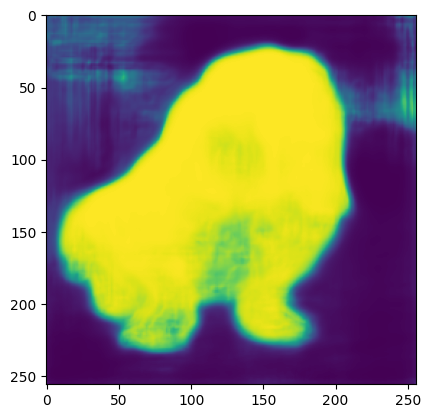

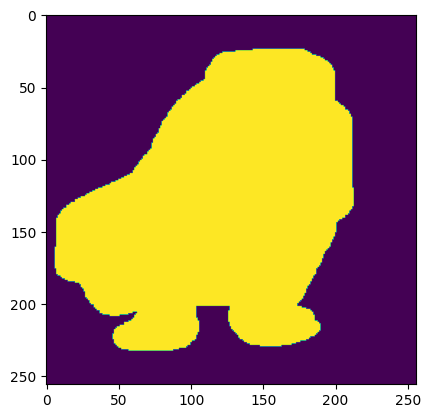

In [24]:
id = 3
plt.imshow(y_pred[id,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[id,:,:].detach().cpu().numpy()); plt.show()

Отметим, что чаще всего предсказания должно быть бинаризированно по некоторому пороговому значению. Это значение можно интерпретировать как порог уверенности (вероятности) с которой мы готовы признать некоторый пиксель принадлежащим объекту или нет.

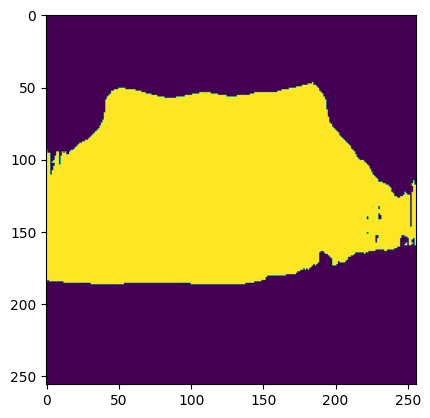

In [25]:
threshold = 0.3
y_pred[y_pred>=threshold]=1
y_pred[y_pred<threshold]=0
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()

**Учебное задание**

**Дано**: набор изобржений `test50.zip`, аналогично работам 5-7.

**Задание**: достичь точности не менее **80%** на тестовом наборе данных `Pets` (аналогично показананому примеру). Для достижения точности рекомендуем или попыться улучшить рассмотренную архитекутру или  попытаться использовать перенос обучения для архитектур, предложенных в библиотеке [`segmentation_models_pytorch`](https://github.com/qubvel/segmentation_models.pytorch). Пример работы с данным модулем будет показан ниже.

**Результат** должен быть подан в виде фала формата `.json`, так, как это показано ниже для демонстрационных данных. 


Проведем загрузку набора данных. Если вы используете Unix- систему, то **демонстрационный** набор можно скачать при помощи следующего кода.


In [26]:
!wget --no-check-certificate 'https://www.dropbox.com/s/chdl1ho5aoedaik/test50.zip?dl=1' -O test_.zip
!unzip test_.zip  
!rm test_.zip


--2023-03-31 10:56:01--  https://www.dropbox.com/s/chdl1ho5aoedaik/test50.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/chdl1ho5aoedaik/test50.zip [following]
--2023-03-31 10:56:07--  https://www.dropbox.com/s/dl/chdl1ho5aoedaik/test50.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0abf3bb1967138730155ff6aa9.dl.dropboxusercontent.com/cd/0/get/B5R6J_KapAGmUY_fMglvQm5qRqBe_K6ZfMJtZzjNXi2OwAgw5UuWR5U7VxGLI3X4vYJBeoZM8xfx29jCbUtjfrCLl2eTTuZufIDbv0UQJ0LD_jfy0Jl2pzFemE252talsqHTdgPDm9ihllSvnc9VhdTysaUnALnsCLhhRe4l9uqRQA/file?dl=1# [following]
--2023-03-31 10:56:07--  https://uc0abf3bb1967138730155ff6aa9.dl.dropboxusercontent.com/cd/0/get/B5R6J_KapAGmUY_fMglvQm5qRqBe_K6ZfMJtZzjNXi2OwAgw5UuWR5U7VxGLI3X4vYJBeoZM8xfx29jCb

Теперь у нас есть директория тестовых изображений, например `demo_`.

In [27]:
test_path = os.path. join(os.getcwd(),'test50')
print(len(os.listdir(test_path)))

51


Перепишем загрузчик данных так, чтобы он работал для тестового набора. В функции `__getitem__` теперь мы будем возвращать изорбажение и название его файла.

In [28]:
class PetsTestDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transforms=None):
        
        self.images_filenames = [x for x in images_filenames if x.endswith('png')]
        self.images_directory = images_directory
        


        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)
    
    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]
        
        path_ = os.path.join(self.images_directory, image_filename)    

        image = np.asarray(Image.open(path_).convert("RGB"))

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed["image"]

        return image, image_filename

In [29]:
test_set = PetsTestDataset(os.listdir(test_path), test_path, test_transform)

testloader = DataLoader(
                test_set,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

Проверим работоспособность загрузчика данных.

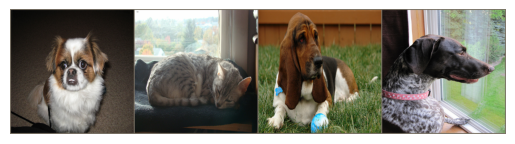

In [30]:
from torchvision.utils import make_grid
images, fnames = next(iter(testloader))
imgs = make_grid(images).data.cpu().numpy().transpose((1,2,0))
imgs = np.clip(imgs*std+mean,0,1)
plt.imshow(imgs);plt.axis('off'); plt.show()

Проведем тестирование и  сохраним резульаты в виде файла формата `json` c разметкой типа таблица. Полученные маски (изображения) будут бинаризироваться по заданому порогу (у нас выбран `0.6`). Бинаризированные макски будут сохраняться в виде контура. Контур может быть получен при помощи функции `find_contours` из библиотеки `skimage`.   

In [31]:
from skimage.measure import find_contours 
def mask2countures(mask):
    return  np.concatenate(find_contours(mask))

In [46]:
threshold = 0.5

df = pd.DataFrame()

model.eval()
with torch.no_grad():
    
    for i, (x, fnames) in enumerate(testloader):

        y_pred = torch.sigmoid(model.forward(x.to(device)))

        y_pred[y_pred>=threshold]=1
        y_pred[y_pred< threshold]=0

        for j, (mask, fname) in enumerate(zip(y_pred, fnames)):
            
            contour = mask2countures(mask.data.cpu().numpy().squeeze())

            df = pd.concat([df,
                            pd.DataFrame([
                                {'id':int(i*BATCH+j),
                                'mask':contour,
                                'shape':mask.data.cpu().numpy().squeeze().shape,
                                'fname':fname}])
                            ], ignore_index=True)

df.to_json('intermediate.json', force_ascii = False, orient = 'table' )

In [47]:
import pandas as pd
import numpy as np
from skimage.draw import polygon
from PIL import Image
import matplotlib.patches as patches

import os

def contours2mask(contours, shape):
    mask = np.zeros(shape)
    rr, cc = polygon(contours[:, 0], contours[:, 1], shape)
    mask[rr, cc] = 1
    return mask

def dice_(pred, target, smooth=1):
    #flatten label and prediction tensors
    target = Image.fromarray(target)
    target = np.array(target.resize(Image.fromarray(pred).size))
    
    pred    = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()                            
    return  (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth) 

def get_masks(df, id_):
    gtmask_    = np.array(df['ground_trugh'].values[id_])
    pred_mask_ = np.array(df['mask'].values[id_])                      
    gtmask     = contours2mask(gtmask_, df['im_shape'].values[id_][:2])
    predmask   = contours2mask(pred_mask_, df['shape'].values[id_][:2])
    
    return gtmask, predmask

def submission(df, path_submission):
    dices = []
    for id_ in range(df.shape[0]):
        gtmask, predmask = get_masks(df, id_)
        dices +=[dice_( gtmask, predmask)]
    return pd.DataFrame(np.array(dices)).to_csv(path_submission)

def create_df(addition = 'demo_.json', predicts = 'intermediate.json' ):
    addition  = pd.read_json(addition,  orient = 'table')
    predicts = pd.read_json(predicts, orient = 'table')
    addition_ = addition.rename(columns={"fname": "old_name", "id":"ans_id", "mask":"ground_trugh", 'shape':'im_shape'})
    return addition_.merge(predicts,left_on='new_fname', right_on='fname')


path_addition     = os.path.join(os.getcwd(),'test50/addition.json') 
path_submission   = os.path.join(os.getcwd(),'submission.csv')
path_intermediate = os.path.join(os.getcwd(),'intermediate.json')

df = create_df(addition = path_addition, predicts = path_intermediate )

acc=submission(df, path_submission)



In [48]:
from google.colab import files

files.download(path_submission)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Также покажем возможность использования переноса обученя для решения задачи семантической сегментации. Будем использовать библиотеку `segmentation_models_pytorch`. Данная библиотека включет реализации ряда популярных архитектур для решения задач семантической сегментации и ряд предобученных блоков. Подробней с бибилотекой можно ознакомится при помощи [официальной документации](https://smp.readthedocs.io/en/latest/) или [репозитория с открытым кодом](https://github.com/qubvel/segmentation_models.pytorch). Попробуем загрузить архитектур `U-Net` c блоком `efficientnet-b0`, предобученным для набора данных `imagenet`.

In [35]:
try:
    import segmentation_models_pytorch
except:
    !pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)

LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=f9670f97033bd97559a9f96bf8887f2f2ccb8fff3b51ffe4c37a16f2a402741f
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=009edb7034d93fa285b618f095c767d1ea8eb5196598b21bdfaa8aef4faf6e30
  Stored in directory: /root/.cache/pip/w

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Загруженная модель может быть обучена при помощи рассмотренных ранее процедур.

Также отметим, что библиотека `segmentation_models_pytorch` включате не только сами архитектуры, но и сопутствующий функционал, например набор [функций потерь](https://smp.readthedocs.io/en/latest/losses.html). Так, например, функция Dice может быть вызвана при помощи следующего кода.
```python
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
criterion.to(device)
```
